In [ ]:
%load_ext autoreload
%autoreload 2

# Wattbot EDA

> This notebook is introduction to the competition [Wattbot 2025](https://www.kaggle.com/competitions/WattBot2025/overview)

I participitated in this competition few months back and was ranked `5th` in the [Private](https://www.kaggle.com/competitions/WattBot2025/leaderboard?) Leaderboard and `10th` in the [Public](https://www.kaggle.com/competitions/WattBot2025/leaderboard?tab=public) Leaderboard. There were 182 entrants

![Leaderboard Ranking](../images/leaderboard_ranking.png)

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| default_exp eda

In [ ]:
#| export
import random
import tiktoken
import time
import urllib
from collections import Counter
import pandas as pd
import contextkit.read as rd
import fastcore.all as fc

### Looking at data

There are 3 [files](https://www.kaggle.com/competitions/WattBot2025/data) shared in the competition 
- metadata.csv
- test_Q.csv
- train_QA.csv

In [ ]:
#| export
data_path = fc.Path(fc.Path.cwd().parent/'data')
data_path.ls(file_exts=['.csv'])

(#5) [Path('/Users/anubhavmaity/projects/wattbot/data/test_Q.csv'),Path('/Users/anubhavmaity/projects/wattbot/data/complete_metadata.csv'),Path('/Users/anubhavmaity/projects/wattbot/data/tst_ans.csv'),Path('/Users/anubhavmaity/projects/wattbot/data/metadata.csv'),Path('/Users/anubhavmaity/projects/wattbot/data/train_QA.csv')]

In [ ]:
#| export
def metadata(): return pd.read_csv(data_path/'metadata.csv', encoding='latin-1')

In [ ]:
metadata().head()

,id,type,title,year,citation,url
0,amazon2023,report,2023 Amazon Sustainability Report,2023,Amazon Staff. (2023). Amazon Sustainability Re...,https://sustainability.aboutamazon.com/2023-am...
1,chen2024,paper,Efficient Heterogeneous Large Language Model D...,2024,"Shaoyuan Chen, Wencong Xiao, Yutong Lin, Mingx...",https://arxiv.org/pdf/2405.01814
2,chung2025,paper,The ML.ENERGY Benchmark: Toward Automated Infe...,2025,"Jae-Won Chung, Jiachen Liu, Jeff J. Ma, Ruofan...",https://arxiv.org/pdf/2505.06371
3,cottier2024,paper,The Rising Costs of Training Frontier AI Models,2024,"Ben Cottier, Robi Rahman, Loredana Fattorini, ...",https://arxiv.org/pdf/2405.21015
4,dodge2022,paper,Measuring the Carbon Intensity of AI in Cloud ...,2022,"Jesse Dodge, Taylor Prewitt, Remi Tachet Des C...",https://arxiv.org/pdf/2206.05229


In [ ]:
len(metadata())

32

In [ ]:
#|export
def train(): return pd.read_csv(data_path/'train_QA.csv')

In [ ]:
train().head()

,id,question,answer,answer_value,answer_unit,ref_id,ref_url,supporting_materials,explanation
0,q003,What is the name of the benchmark suite presen...,The ML.ENERGY Benchmark,ML.ENERGY Benchmark,is_blank,['chung2025'],['https://arxiv.org/pdf/2505.06371'],"We present the ML.ENERGY Benchmark, a benchmar...",Quote
1,q009,What were the net CO2e emissions from training...,4.3 tCO2e,4.3,tCO2e,['patterson2021'],['https://arxiv.org/pdf/2104.10350'],"""Training GShard-600B used 24 MWh and produced...",Quote
2,q054,What is the model size in gigabytes (GB) for t...,64.7 GB,64.7,GB,['chen2024'],['https://arxiv.org/pdf/2405.01814'],Table 3: Large language models used for evalua...,Table 3
3,q062,What was the total electricity consumption of ...,Unable to answer with confidence based on the ...,is_blank,MWh,is_blank,is_blank,is_blank,is_blank
4,q075,True or False: Hyperscale data centers in 2020...,TRUE,1,is_blank,"['wu2021b','patterson2021']","['https://arxiv.org/abs/2108.06738','https://a...","Wu 2021, body text near Fig. 1: ""…between trad...",The >40% statement is explicit in Wu. Patterso...


In [ ]:
#|export
def get_train_data(idx=-1):
    t = train()
    if idx == -1: idx = random.randint(0, len(t))
    return fc.NS(**t.iloc[idx])

In [ ]:
get_train_data()

namespace(id='q166',
          question='Which of the following five large NLP DNNs has the highest energy consumption: Meena, T5, GPT-3, GShard-600B, or Switch Transformer?',
          answer='GPT-3',
          answer_value='GPT-3',
          answer_unit='is_blank',
          ref_id="['patterson2021']",
          ref_url="['https://arxiv.org/pdf/2104.10350']",
          supporting_materials='Figure 3',
          explanation='Figure')

In [ ]:
get_train_data(0)

namespace(id='q003',
          question='What is the name of the benchmark suite presented in a recent paper for measuring inference energy consumption?',
          answer='The ML.ENERGY Benchmark',
          answer_value='ML.ENERGY Benchmark',
          answer_unit='is_blank',
          ref_id="['chung2025']",
          ref_url="['https://arxiv.org/pdf/2505.06371']",
          supporting_materials='We present the ML.ENERGY Benchmark, a benchmark suite and tool for measuring inference energy consumption under realistic service environments...',
          explanation='Quote')

In [ ]:
#|export
def get_value(row):
    return fc.NS(**row)

In [ ]:
get_value(train().iloc[0])

namespace(id='q003',
          question='What is the name of the benchmark suite presented in a recent paper for measuring inference energy consumption?',
          answer='The ML.ENERGY Benchmark',
          answer_value='ML.ENERGY Benchmark',
          answer_unit='is_blank',
          ref_id="['chung2025']",
          ref_url="['https://arxiv.org/pdf/2505.06371']",
          supporting_materials='We present the ML.ENERGY Benchmark, a benchmark suite and tool for measuring inference energy consumption under realistic service environments...',
          explanation='Quote')

In [ ]:
#|export
def test(): return pd.read_csv(data_path/'test_Q.csv')

In [ ]:
test().head()

,id,question,answer,answer_value,answer_unit,ref_id,ref_url,supporting_materials,explanation
0,q001,What was the average increase in U.S. data cen...,NaN,NaN,percent,NaN,NaN,NaN,NaN
1,q002,"In 2023, what was the estimated amount of cars...",NaN,NaN,cars,NaN,NaN,NaN,NaN
2,q004,How many data centers did AWS begin using recy...,NaN,NaN,data centers,NaN,NaN,NaN,NaN
3,q005,Since NVIDIA doesn't release the embodied carb...,NaN,NaN,kg/GPU,NaN,NaN,NaN,NaN
4,q006,By what factor was the estimated amortized tra...,NaN,NaN,ratio,NaN,NaN,NaN,NaN


### How many papers and reports?

<Axes: >

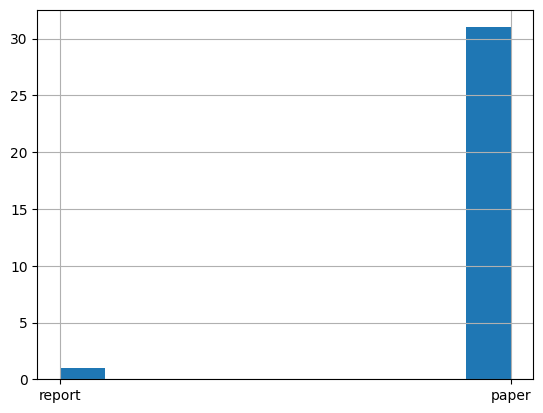

In [ ]:
metadata()['type'].hist()

In [ ]:
metadata()[metadata()['type'] == 'report']

,id,type,title,year,citation,url
0,amazon2023,report,2023 Amazon Sustainability Report,2023,Amazon Staff. (2023). Amazon Sustainability Re...,https://sustainability.aboutamazon.com/2023-am...


### How is the distribution of arxiv?

In [ ]:
#|export
def is_arxiv(url): return 'arxiv' in url

In [ ]:
is_arxiv(metadata().iloc[0]['url'])

False

In [ ]:
Counter(metadata()['url'].map(lambda x: is_arxiv(x)))

Counter({True: 31, False: 1})

Most of them are arxiv

### How is the distribution of title length?

<Axes: >

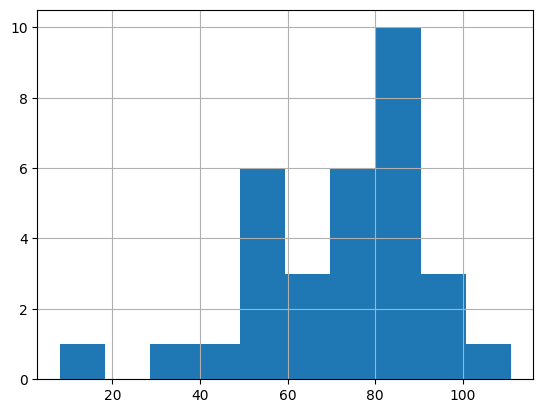

In [ ]:
metadata()['title'].map(lambda x: len(x)).hist()

### Download the pdf

In [ ]:
#|export
def download_pdf(url): 
    url = url.strip()
    filename = data_path/fc.Path(url).name
    if filename.suffix != '.pdf': filename = filename.with_name(f"{filename.name}.pdf")
    if not filename.exists(): fc.urlretrieve(url, filename)
    return filename

In [ ]:
md = metadata()

In [ ]:
url = md.iloc[0].url
download_pdf(url)

Path('../data/2023-amazon-sustainability-report.pdf')

In [ ]:
download_pdf('https://arxiv.org/pdf/2405.01814v2')

Path('../data/2405.01814v2.pdf')

In [ ]:
md['filepath'] = md['url'].map(download_pdf)

### Read the pdfs into dataframe

In [ ]:
md['content'] = md['filepath'].map(rd.read_pdf)

In [ ]:
md.head()

,id,type,title,year,citation,url,filepath,content
0,amazon2023,report,2023 Amazon Sustainability Report,2023,Amazon Staff. (2023). Amazon Sustainability Re...,https://sustainability.aboutamazon.com/2023-am...,../data/2023-amazon-sustainability-report.pdf,Amazon \nSustainability \nReport\n2023 Content...
1,chen2024,paper,Efficient Heterogeneous Large Language Model D...,2024,"Shaoyuan Chen, Wencong Xiao, Yutong Lin, Mingx...",https://arxiv.org/pdf/2405.01814,../data/2405.01814.pdf,Efficient Heterogeneous Large Language Model D...
2,chung2025,paper,The ML.ENERGY Benchmark: Toward Automated Infe...,2025,"Jae-Won Chung, Jiachen Liu, Jeff J. Ma, Ruofan...",https://arxiv.org/pdf/2505.06371,../data/2505.06371.pdf,The ML.ENERGY Benchmark: Toward Automated\nInf...
3,cottier2024,paper,The Rising Costs of Training Frontier AI Models,2024,"Ben Cottier, Robi Rahman, Loredana Fattorini, ...",https://arxiv.org/pdf/2405.21015,../data/2405.21015.pdf,THE RISING COSTS OF TRAINING FRONTIER AI MODEL...
4,dodge2022,paper,Measuring the Carbon Intensity of AI in Cloud ...,2022,"Jesse Dodge, Taylor Prewitt, Remi Tachet Des C...",https://arxiv.org/pdf/2206.05229,../data/2206.05229.pdf,Measuring the Carbon Intensity of AI in Cloud ...


In [ ]:
md['content_length'] = md['content'].map(lambda x: len(x))

<Axes: >

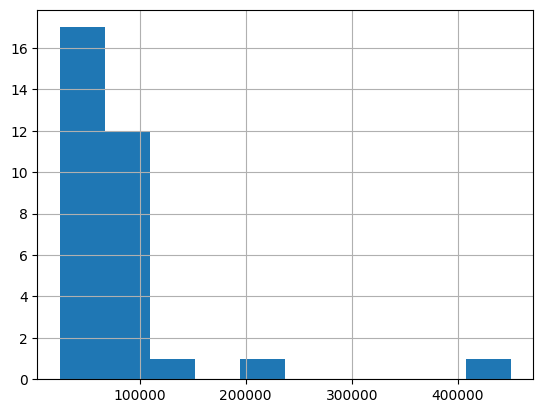

In [ ]:
md['content_length'].hist()

### Content Tokens

In [ ]:
encoding = tiktoken.get_encoding("cl100k_base")

In [ ]:
#|export
def compute_tokens(msg):
    tokens = encoding.encode(msg)
    return len(tokens)

In [ ]:
msg = md.iloc[0]['content']
compute_tokens(msg)

95785

In [ ]:
md['token_count'] = md['content'].map(compute_tokens)

<Axes: >

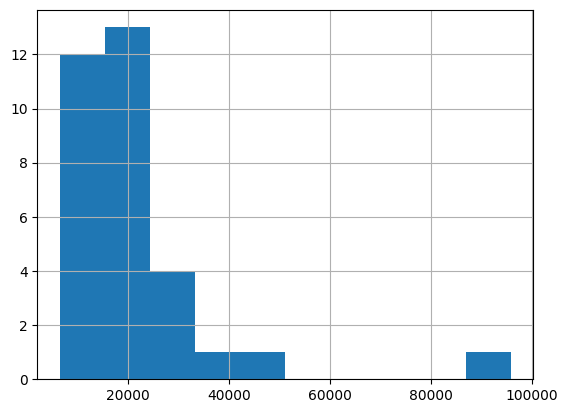

In [ ]:
md['token_count'].hist()

### Save metadata file

In [ ]:
md.to_csv(data_path/'complete_metadata.csv', index=False)

### Create submission file

In [ ]:
def create_submission(answers_list, output_path='submission.csv'):
    df = test()
    
    for i, answer in enumerate(answers_list):
        df.loc[i, 'answer'] = answer['answer']
        df.loc[i, 'answer_value'] = answer['answer_value']
        df.loc[i, 'answer_unit'] = answer['answer_unit']
        df.loc[i, 'ref_id'] = answer['ref_id']
        df.loc[i, 'ref_url'] = answer['ref_url']
        df.loc[i, 'supporting_materials'] = answer['supporting_materials']
        df.loc[i, 'explanation'] = answer['explanation']
    
    df = df.fillna('is_blank')
    df.to_csv(output_path, index=False)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()